In [1]:
import numpy as np 
import xarray as xr 
import pandas as pd
import datetime
import comet as cm

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util




### Read in data

In [2]:
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/day/CLM5_revertVars/'

fileCLM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-CLM45physics.002.clm2.h1.1979-83_SoilWater10cm.nc'
fileCAM = dataDir+'f.e21.FHIST.f09_f09_mg17.CESM2-CLM45physics.002.cam.h1.1979-83_CIvars.nc'

camDS_CLM45         = xr.open_dataset(fileCAM, decode_times=True)
camDS_CLM45['time'] = camDS_CLM45.indexes['time'].to_datetimeindex()
print('Finished reading in CAM file')

clmDS_CLM45         = xr.open_dataset(fileCLM, decode_times=True)
clmDS_CLM45['time'] = clmDS_CLM45.indexes['time'].to_datetimeindex()
print('Finished reading in CLM file')



Finished reading in CAM file
Finished reading in CLM file


<ipython-input-2-85d09a089033>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_CLM45['time'] = camDS_CLM45.indexes['time'].to_datetimeindex()
<ipython-input-2-85d09a089033>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_CLM45['time'] = clmDS_CLM45.indexes['time'].to_datetimeindex()


## Base off of Ahmed's python script here: 

In [3]:
# Make one big xr.Dataset containing all the information we need  
ds = camDS_CLM45
ds['SOILWATER_10CM'] = (('time','lat','lon'), clmDS_CLM45.SOILWATER_10CM.values)


In [ ]:
# # fields = ['SOILWATER_10CM','EFLX_LH_TOT']
# fields = ['SOILWATER_10CM','FSH_TO_COUPLER']  # Soil moisture & SHFLX (as sent to coupler)
# ds = get_ds(fields)
# ds

In [56]:
xname = 'SOILWATER_10CM'
yname = 'SHFLX'

# xday = ds[xname].resample({'time':'1D'}).mean().groupby('time.season')
# yday = ds[yname].resample({'time':'1D'}).mean().groupby('time.season')

xday = ds[xname].groupby('time.season')
yday = ds[yname].groupby('time.season')

covarTerm = ((xday - xday.mean()) * (yday - yday.mean())).groupby('time.season').sum() / xday.count()

couplingIndex = covarTerm/xday.std()


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [33]:
np.nanmean(couplingIndex[1,:,:])

-8.181537856698116

In [59]:
((xday - xday.mean()) * (yday - yday.mean()))

/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray (time: 1826, lat: 192, lon: 288)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1984-01-01
    season   (time) <U3 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF'

### What's happening with resample?

In [3]:
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/Monthly/CLM45/'
monthlyFile_flx = dataDir+'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h0.2000-2005_sfcFluxes.nc'
monthlyFile_SM  = dataDir+'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h0.2000-2005_SOILWATER10.nc'

flxDS_mon = xr.open_dataset(monthlyFile_flx, decode_times=True)
flxDS_mon['time'] = flxDS_mon.indexes['time'].to_datetimeindex()

smDS_mon = xr.open_dataset(monthlyFile_SM, decode_times=True)
smDS_mon['time'] = smDS_mon.indexes['time'].to_datetimeindex()


<ipython-input-3-c38eba469f69>:6: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  flxDS_mon['time'] = flxDS_mon.indexes['time'].to_datetimeindex()
<ipython-input-3-c38eba469f69>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  smDS_mon['time'] = smDS_mon.indexes['time'].to_datetimeindex()


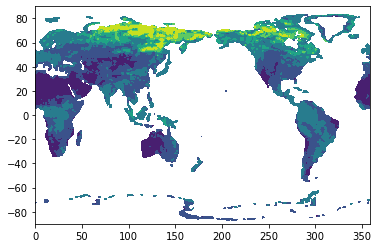

In [10]:
plt.contourf(smDS_mon.lon.values,smDS_mon.lat.values,smDS_mon[xname].values[10,:,:])

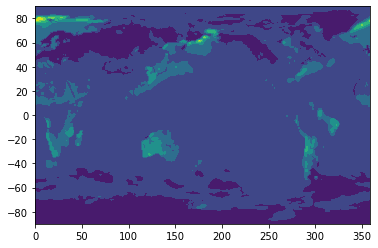

In [11]:
plt.contourf(flxDS_mon.lon.values,flxDS_mon.lat.values,flxDS_mon[yname].values[10,:,:])

In [19]:
# Make one big xr.Dataset containing all the information we need  
ds = flxDS_mon
ds['SOILWATER_10CM'] = (('time','lat','lon'), smDS_mon.SOILWATER_10CM.values)



In [24]:
xname = 'SOILWATER_10CM'
yname = 'SHFLX'

xday = ds[xname].resample({'time':'1D'}).mean().groupby('time.season')
yday = ds[yname].resample({'time':'1D'}).mean().groupby('time.season')

# xday = ds[xname].groupby('time.season')
# yday = ds[yname].groupby('time.season')

covarTerm = ((xday - xday.mean()) * (yday - yday.mean())).groupby('time.season').sum() / xday.count()

couplingIndex = covarTerm/xday.std()



/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [22]:
np.nanmean(couplingIndex[1,:,:])

-6.804064889057713

In [25]:
np.nanmean(couplingIndex[1,:,:])

-6.804064889057713

In [21]:
testResample2 = smDS_mon[xname].resample({'time':'1D'}).mean()

In [26]:
smDS_mon

<xarray.Dataset>
Dimensions:         (hist_interval: 2, lat: 192, lon: 288, time: 72)
Coordinates:
  * time            (time) datetime64[ns] 2000-02-01 2000-03-01 ... 2006-01-01
  * lon             (lon) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
  * lat             (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
Dimensions without coordinates: hist_interval
Data variables:
    time_bounds     (time, hist_interval) object ...
    SOILWATER_10CM  (time, lat, lon) float32 ...
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   Tue Sep 29 09:27:34 2020: ncrc...
    source:                                    Community Land Model CLM4.0
    hostname:                                  cheyenne
    username:                                  hannay
    version:                                   cesm2.1.1-exp17
    revision_id:                               $Id: histFileMod.F90 42903 201...
    case_title:                                UNSET
    case_id:                                   f.e20.FHIST.f09_f09.cesm2_1_cl...
    Surface_dataset:                           surfdata_0.9x1.25_hist_16pfts_...
    Initial_conditions_dataset:                arbitrary initialization
    PFT_physiological_constants_dataset:       clm_params.c170913.nc
    ltype_vegetated_or_bare_soil:              1
    ltype_crop:                                2
    ltype_UNUSED:                              3
    ltype_landice_multiple_elevation_classes:  4
    ltype_deep_lake:                           5
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9
    ctype_vegetated_or_bare_soil:              1
    ctype_crop:                                2
    ctype_crop_noncompete:                     2*100+m, m=cft_lb,cft_ub
    ctype_landice:                             3
    ctype_landice_multiple_elevation_classes:  4*100+m, m=1,glcnec
    ctype_deep_lake:                           5
    ctype_wetland:                             6
    ctype_urban_roof:                          71
    ctype_urban_sunwall:                       72
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./f.e20.FHIST.f09_f09.cesm2_1_...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...
    NCO:                                       netCDF Operators version 4.7.9...

In [28]:
smDS_mon.SOILWATER_10CM.values[:,120,200]

array([ 7.3506985,  8.017492 ,  8.274174 ,  7.4084   ,  7.2128267,
        7.1359296,  8.487063 ,  7.946712 , 10.644889 , 10.939372 ,
        8.588856 ,  7.8139424,  7.6468215,  7.336437 ,  8.257264 ,
        7.5397954,  7.291109 ,  7.219929 ,  7.1428204,  8.887676 ,
       10.742615 ,  7.5528975,  7.2602654,  7.1930714,  8.723995 ,
        8.480621 ,  7.7608476,  7.66485  ,  7.37055  ,  7.2233095,
        7.63525  ,  7.321258 ,  9.004702 ,  7.7478995,  7.7397017,
        7.9680905, 14.9434185, 12.815184 , 11.866061 ,  8.218248 ,
        7.4860177,  7.4199286,  7.713141 ,  7.2906528,  7.621982 ,
        7.313528 ,  7.2167716,  7.6301284,  7.5861554,  7.5928636,
        7.5506606,  7.8195453,  7.2629504,  7.194107 ,  7.3777804,
        7.9473777, 13.478857 ,  7.6085544,  7.585482 , 13.161855 ,
       16.773415 ,  9.839684 ,  8.831545 ,  7.704231 ,  7.4554014,
        7.4028587,  7.37782  ,  8.28383  , 13.247179 ,  8.066718 ,
        7.3426404,  7.2546577], dtype=float32)

In [30]:
testResample2[0:31,120,200]

<xarray.DataArray 'SOILWATER_10CM' (time: 31)>
array([7.3506985,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan, 8.017492 ,
             nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-02-01 2000-02-02 ... 2000-03-02
    lon      float32 250.0
    lat      float32 23.089005

In [9]:
testResample = ds[xname].resample({'time':'1D'}).mean()

/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [19]:
testResample

<xarray.DataArray 'SOILWATER_10CM' (time: 1827, lat: 192, lon: 288)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1984-01-01
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [15]:
ds[xname].time

<xarray.DataArray 'time' (time: 1826)>
array(['1979-01-01T00:00:00.000000000', '1979-01-02T00:00:00.000000000',
       '1979-01-03T00:00:00.000000000', ..., '1983-12-30T00:00:00.000000000',
       '1983-12-31T00:00:00.000000000', '1984-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1984-01-01

In [21]:
np.nanmean(couplingIndex[7,:,:])

-7.975338563186384

In [23]:
np.nanmean(couplingIndex[1,:,:])

-8.181537856698116

In [6]:
# Compute coupling index 
terraLeg_coupling_CLM45 = cm.metrics.CouplingIndex()
terraLeg_coupling_CLM45 = terraLeg_coupling_CLM45.compute(ds, xname='SOILWATER_10CM',yname='SHFLX',averaging='season')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [8]:
cometCI = terraLeg_coupling_CLM45.SOILWATER_10CM_SHFLX_CI

In [11]:
np.nanmin(couplingIndex - cometCI)

0.0